# Keras colorizer of CelebA using Generative Adversarial Networks.
The dataset can be downloaded from: https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADIKlz8PR9zr6Y20qbkunrba/Img/img_align_celeba.zip?dl=0
## Instrustion on running the script:
1. Download the dataset from the provided link
2. Save the folder 'img_align_celeba' to 'datasets/'

In [ ]:
! python

In [2]:
tf.__version__

'1.14.0'

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
D:\Anaconda3\envs\colorizer2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\colorizer2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\colorizer2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\colorizer2\lib\site-packages\tensorflow\python\fra

['/job:localhost/replica:0/task:0/device:GPU:0']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
! mkdir datasets
! mkdir originals

In [ ]:
! unzip -q "/content/drive/My Drive/img_align_celeba.zip" -d datasets

In [ ]:
! unzip -q "/content/drive/My Drive/coco_val2017.zip" -d datasets

In [ ]:
! mv datasets/val2017/* originals

In [ ]:
! find /content/datasets/img_align_celeba -type f -exec sh -c 'mv "$@" "$0"' originals/ {} +

In [23]:
! pip install segmentation-models

In [3]:
import scipy
import tensorflow as tf
#from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add, MaxPooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
import keras
#from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from glob import glob
import keras.backend as K
#import scipy.misc
import PIL
from PIL import Image
import os
#import skimage.io as io
#import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.optimizers import Adam
#import segmentation_models as sm

In [25]:
! pip install --upgrade pip

  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'd:\\anaconda3\\scripts\\pip.exe'
Consider using the `--user` option or check the permissions.



In [3]:
! python -m pip install --upgrade pip

D:\Anaconda3\python.exe: No module named pip


In [10]:
! pip install --upgrade tensorflow

Script file 'D:\Anaconda3\Scripts\pip-script.py' is not present.


In [8]:
! pip install --upgrade keras

Requirement already up-to-date: keras in d:\anaconda3\lib\site-packages (2.3.1)


In [2]:
#import keras 
import tensorflow as tf
#keras.__version__
tf.__version__

'1.14.0'

In [17]:
tf.core

<module 'tensorflow.core' (namespace)>

In [20]:
! pip uninstall tensorflow

Script file 'D:\Anaconda3\Scripts\pip-script.py' is not present.


In [4]:
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 3} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [3]:
preprocess_input = sm.get_preprocessing('resnet34')

In [4]:
preprocess_input

<function classification_models.models.resnet.preprocess_input(x, **kwargs)>

In [151]:
class DataLoader():
  def __init__(self, img_res=(256, 256)):
    self.img_res = img_res

  def load_data(self, batch_size=1, is_testing=False):
    path = glob('./originals/*')
    batch_images = np.random.choice(path, size=batch_size)

    imgs_hr = []
    imgs_lr = []
    for img_path in batch_images:
      img_hr, img_lr = self._load(img_path, self.img_res)

      imgs_hr.append(img_hr)
      imgs_lr.append(img_lr)
      
    # нормализация данных
    imgs_hr = np.array(imgs_hr) / 127.5 - 1
    imgs_lr = np.array(imgs_lr) / 127.5 - 1

    return imgs_hr, imgs_lr

  # returns pair (original photo, grayscale photo)
  def _load(self, path, size):
    img = Image.open(path).resize(size).convert('RGB')
    orig = np.array(img).astype(np.float)
    import random
    crap_width = random.randint(100, 512)
    crap_size = (crap_width, crap_width)
    gray = np.expand_dims(np.array(img.resize(crap_size).resize(size).convert('L')).astype(np.float), axis=2)
    # np.expand_dims(np.array(Image.open(path).resize(size).convert('L')).astype(np.float), axis=2)
    return orig, gray

In [152]:
hr_channels = 3
lr_channels = 1
width = 512
lr_shape = (width, width, lr_channels)
hr_shape = (width, width, hr_channels)

n_residual_blocks = 16
optimizer = Adam(0.0002, 0.5)

# configure data loader
data_loader = DataLoader(img_res=(width, width))

In [25]:
def sample_images(epoch):
  os.makedirs('samples', exist_ok=True)
  r,c = 2,3
  imgs_hr, imgs_lr = data_loader.load_data(batch_size=2, is_testing=True)
  fake_hr = generator.predict(imgs_lr)
  imgs_lr = 0.5 * imgs_lr + 0.5
  fake_hr = 0.5 * fake_hr + 0.5
  imgs_hr = 0.5 * imgs_hr + 0.5
  titles = ["B&W", "Generated", "Original"]
  fig, axs = plt.subplots(r, c)
  cnt = 0
  for row in range(r):
    for col, image in enumerate([imgs_lr, fake_hr, imgs_hr]):
        if col == 0:
            axs[row, col].imshow(np.array(Image.fromarray((np.squeeze(image[row])*255).astype(np.uint8)).convert('RGB')))
        else:
            axs[row, col].imshow(image[row])
        axs[row, col].set_title(titles[col])
        axs[row, col].axis('off')
    cnt += 1
  def zerofy(s: str):
    while len(s) < 6:
      s = '0' + s
    return s
  fig.savefig('samples/'+zerofy(str(epoch)) +'.png')
  plt.close()

We use a pre-trained VGG19 model to extract image features from the high resolution and the generated high resolution images and minimize the mse between them

In [26]:
def build_feature_loss(input_size):
  vgg = VGG19(weights='imagenet')
  vgg.outputs = [vgg.layers[9].output]
  img = Input(shape=input_size)
  img_features = vgg(img)
  model = Model(img, img_features)
  model.trainable = False 
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model
feature_loss = build_feature_loss(hr_shape)

build and compile the discriminator

In [27]:
def build_discriminator(input_size):
  # Number of filters in the first layer of G and D
  gf = 64
  df = 64
  def d_block(layer_input, filters, strides=1, bn=True):
    """Discriminator layer"""
    d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if bn:
        d = BatchNormalization(momentum=0.8)(d)
    return d

  # Input img
  d0 = Input(shape=input_size)

  d1 = d_block(d0, df, bn=False)
  d2 = d_block(d1, df, strides=2)
  d3 = d_block(d2, df*2)
  d4 = d_block(d3, df*2, strides=2)
  d5 = d_block(d4, df*4)
  d6 = d_block(d5, df*4, strides=2)
  d7 = d_block(d6, df*8)
  d8 = d_block(d7, df*8, strides=2)

  d9 = Dense(df*16)(d8)
  d10 = LeakyReLU(alpha=0.2)(d9)
  validity = Dense(1, activation='sigmoid')(d10)

  model = Model(d0, validity)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

discriminator = build_discriminator(input_size=hr_shape)

Build the generator

In [28]:
def unet(pretrained_weights = None, input_size = (256, 256, 3)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(3, 1, activation = 'tanh')(conv9)

  model = Model(input = inputs, output = conv10)
  
  #model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)
  model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy'])
  return model
generator = unet(input_size=lr_shape)
#generator = sm.Unet('resnet34', input_shape=(width, width, 3), encoder_weights='imagenet', classes=3, activation="tanh", encoder_freeze=True,decoder_filters=(1024, 512,256, 128, 64))
#generator.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy'])

D:\Anaconda3\envs\colorizer2\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [29]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 512, 512, 64) 640         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_73[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_74[0][0]                  
__________________________________________________________________________________________________
conv2d_75 

In [30]:
def build_gan(input_size):
  # High res. and low res. images
  img_lr = Input(shape=lr_shape)
  # generate high res. version from low res.
  fake_hr = generator(img_lr)
  # extract image features of the generated img
  fake_features = feature_loss(fake_hr)
  # for the combined model we will only train the generator
  discriminator.trainable = False
  # Discriminator determines validity of generated high res. images
  validity = discriminator(fake_hr)
  combined = Model([img_lr], [validity, fake_features])
  combined.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=optimizer)
  return combined
gan = build_gan(lr_shape)

## Train

In [170]:
#! rm -rf ./samples
epochs=100000
batch_size=1
sample_interval=50
start_time = datetime.datetime.now()
for epoch in range(epochs+1):
    # calculate output shape of D (PatchGAN)
    patch = int(width / 2**4)
    disc_patch = (patch, patch, 1)
    # ----------------------
    #  Train Discriminator
    # ----------------------

    # Sample images and their conditioning counterparts
    imgs_hr, imgs_lr = data_loader.load_data(batch_size)

    # From low res. image generate high res. version
    fake_hr = generator.predict(imgs_lr)

    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)

    # Train the discriminators (original images = real / generated = Fake)
    d_loss_real = discriminator.train_on_batch(imgs_hr, valid)
    d_loss_fake = discriminator.train_on_batch(fake_hr, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ------------------
    #  Train Generator
    # ------------------

    # Sample images and their conditioning counterparts
    imgs_hr, imgs_lr = data_loader.load_data(batch_size)

    # The generators want the discriminators to label the generated images as real
    valid = np.ones((batch_size,) + disc_patch)

    # Extract ground truth image features using pre-trained VGG19 model
    image_features = feature_loss.predict(imgs_hr)

    # Train the generators
    g_loss = gan.train_on_batch([imgs_lr], [valid, image_features])

    elapsed_time = datetime.datetime.now() - start_time
    # Plot the progress
    print ("%d time: %s" % (epoch, elapsed_time))

    # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
        sample_images(epoch)
    if epoch % 1000 == 0:
        save_generator = keras.Sequential([generator])
        save_generator.add(Lambda(lambda x: (x + 1) * 127.5))
        save_generator.save('generator512_2' + str(epoch) + '.h5')

0 time: 0:00:03.008982
1 time: 0:00:08.225035
2 time: 0:00:11.223013
3 time: 0:00:14.231968
4 time: 0:00:17.209983
5 time: 0:00:20.218969
6 time: 0:00:23.199004
7 time: 0:00:26.187983
8 time: 0:00:29.177989
9 time: 0:00:32.215866
10 time: 0:00:35.243770
11 time: 0:00:38.242750
12 time: 0:00:41.218816
13 time: 0:00:44.239757
14 time: 0:00:47.257666
15 time: 0:00:50.247670
16 time: 0:00:53.222715
17 time: 0:00:56.204743
18 time: 0:00:59.177817
19 time: 0:01:02.176802
20 time: 0:01:05.153814
21 time: 0:01:08.188699
22 time: 0:01:11.174715
23 time: 0:01:14.160753
24 time: 0:01:17.198607
25 time: 0:01:20.207562
26 time: 0:01:23.195602
27 time: 0:01:26.218513
28 time: 0:01:29.209492
29 time: 0:01:32.232409
30 time: 0:01:35.238372
31 time: 0:01:38.267345
32 time: 0:01:41.306227
33 time: 0:01:44.279301
34 time: 0:01:47.257385
35 time: 0:01:50.255346
36 time: 0:01:53.223432
37 time: 0:01:56.196483
38 time: 0:01:59.190454
39 time: 0:02:02.162530
40 time: 0:02:05.133587
41 time: 0:02:08.142527
42

KeyboardInterrupt: 

In [181]:
img = Image.open('test9.jpg').resize((500, 500)).resize((512, 512)).resize((512, 512))
t = np.expand_dims(np.array(img.convert('L')).astype(np.float), axis=2)
a = np.array([t]) / 127.5 - 1
res = generator.predict(a)
res = 0.5 * res + 0.5
res = res[0]
Image.fromarray(np.uint8(res * 255))
#img

FileNotFoundError: [Errno 2] No such file or directory: 'test9.jpg'

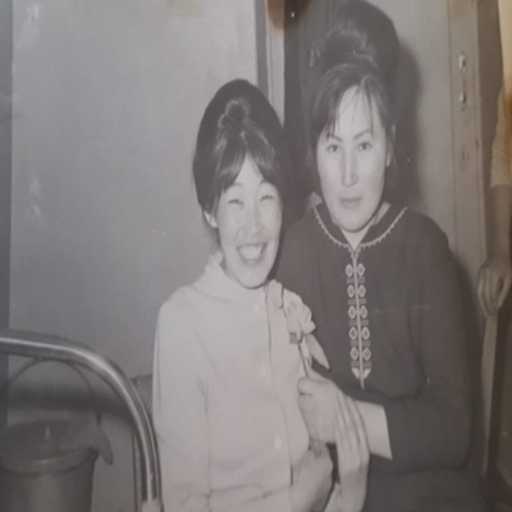

In [137]:
img = Image.open('test7.jpg').resize((400, 400)).resize((512, 512))
img

In [124]:
import random

In [128]:
random.randint(100, 512)

297

In [20]:
! pip install --upgrade tensorflow==2.2

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'd:\\anaconda3\\envs\\colorizer\\lib\\site-packages\\~ensorflow_core\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



  Using cached tensorflow-2.2.0-cp37-cp37m-win_amd64.whl (459.2 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [34]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [ ]:
generator.summary()

In [171]:
save_generator = keras.Sequential([generator])
save_generator.add(Lambda(lambda x: (x + 1) * 127.5))
save_generator.save('generator512_2.h5')

## Convert to CoreML

In [116]:
np.array(Image.open('test.jpg').convert('L')).max()

255

In [68]:
! pip install coremltools

ERROR: Could not find a version that satisfies the requirement coremltools (from versions: none)
ERROR: No matching distribution found for coremltools


In [ ]:
! pip install keras==2.2.4
! pip install tensorflow==1.14.0

  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [66]:
from coremltools.proto import NeuralNetwork_pb2

def convert_lambda(layer):
    params = NeuralNetwork_pb2.CustomLayerParams()

    # The name of the Swift or Obj-C class that implements this layer.
    params.className = "Lambda"

    # The desciption is shown in Xcode's mlmodel viewer.
    params.description = "Post process"

    return params

ModuleNotFoundError: No module named 'coremltools'

In [67]:
import coremltools
coreml_model = coremltools.converters.keras.convert('generator.h5', input_names='input', output_names='output', image_input_names='input', add_custom_layers=True, image_scale=2/255, gray_bias=-1, red_bias=-1, custom_conversion_functions={ "Lambda": convert_lambda }, use_float_arraytype=True)

# Saving the Core ML model to a file.
coreml_model.save('colorizer.mlmodel')

ModuleNotFoundError: No module named 'coremltools'

In [ ]:
import coremltools
import coremltools.proto.FeatureTypes_pb2 as ft 

spec = coremltools.utils.load_spec("colorizer.mlmodel")

In [ ]:
output = spec.description.output[0]
width = 512
import coremltools.proto.FeatureTypes_pb2 as ft
output.type.imageType.colorSpace = ft.ImageFeatureType.RGB
output.type.imageType.height = width
output.type.imageType.width = width

coremltools.utils.save_spec(spec, "Colorizer.mlmodel")

In [ ]:
#! pip uninstall keras
#! pip uninstall tensorflow
! pip install tensorflow
! pip install keras